 # hawaii, snapshot, movies

---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from dask import delayed
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#cluster = PBSCluster(cores=12, processes=12, walltime='01:00:00')
cluster = PBSCluster(cores=6, processes=6, mem='30gb', walltime='01:00:00')
#w = cluster.scale(12*4)
w = cluster.scale(12*20)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.135.39.90:52814 Dashboard: http://10.135.39.90:8787/status,Cluster Workers: 6 Cores: 6 Memory: 100.02 GB


---


## define a region of interest

In [6]:
region = 'hawaii'
lon = [-170, -150]
lat = [10, 30]
faces = [7, 8]

#v, vmin, vmax = 'Eta', -.5, 1.5
v, vmin, vmax = 'SSU', -1., 1.
#v, vmin, vmax = 'SST', 23., 28.

In [7]:
# param dict for plotting
params = {'faces':faces,'extent':lon+lat,'projection': ccrs.PlateCarree(),
          'dticks':[5,5]}

# load grid
grd = load_grd()
grd

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
    CS       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Depth    (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    PHrefC   (k) float32 dask.array<shape=(90,), chunksize=(90,)>
    PHrefF   (k_p1) float32 dask.array<shape=(91,), chunksize=(91,)>
    SN       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    XG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YG       (face, j_g, i_g) float32 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    Z        (k) float32 dask.array<shape=(90,), chunksi

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/mp/pontea/.conda/envs/equinox/lib/

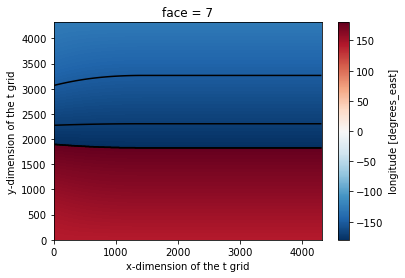

In [8]:
xc = grd.XC.isel(i=slice(0,None,4),j=slice(0,None,4), face=faces[0])
yc = grd.YC.isel(i=slice(0,None,4),j=slice(0,None,4), face=faces[0])

xc.plot()
xc.plot.contour(levels=lon, colors='k', linestyles='-')

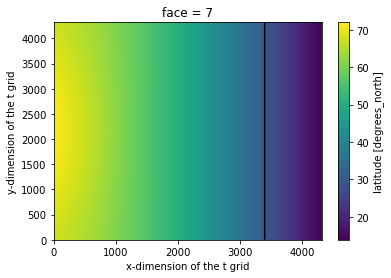

In [9]:
yc.plot()
yc.plot.contour(levels=lat, colors='k', linestyles='-')

In [10]:
islice = slice(3200,4500)
jslice = slice(2100, 3500)

---

## load grid and data

In [8]:
if v in ['Eta','SST','SSS']:
    ds = load_data(v)
elif v in ['SSU','SSV']:
    dsu = load_data('SSU').rename({'i_g':'i'})
    dsv = load_data('SSV').rename({'j_g':'j'})
    ds = xr.merge([dsu, dsv])      
ds = (ds.assign_coords(XC=grd.XC, YC=grd.YC)
       .drop(['Depth','rA', 'hFacC']))

ds = ds.sel(face=faces)
#ds = ds.isel(i=islice, j=jslice)
ds = ds.isel(i=slice(0,None,2),j=slice(0,None,2))


# rotate if necessary
if v in ['SSU','SSV']:
    ds['SSU_geo'], ds['SSV_geo'] = rotate(ds.SSU, ds.SSV, ds)
    ds = ds.drop(['SSU','SSV'])
    if v is 'SSU': v = 'SSU_geo' 
    if v is 'SSV': v = 'SSV_geo' 
print(ds)
print(v)

print('\n data set (all faces): %.1f GB' %(ds.nbytes / 1e9))
print('\n variable size (all faces): %.1f GB' %(ds[v].nbytes / 1e9))
print('\n data size (1 time): %.1f GB' %(ds[v].isel(time=0).nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 2, i: 2160, j: 2160, time: 8785)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8785,), chunksize=(8785,)>
  * face     (face) int64 7 8
  * i        (i) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
    iters    (time) int64 dask.array<shape=(8785,), chunksize=(1,)>
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
    CS       (face, j, i) float32 dask.array<shape=(2, 2160, 2160), chunksize=(1, 2160, 2160)>
    SN       (face, j, i) float32 dask.array<shape=(2, 2160, 2160), chunksize=(1, 2160, 2160)>
    YC       (face, j, i) float32 dask.array<shape=(2, 2160, 2160), chunksize=(1, 2160, 2160)>
    XC       (face, j, i) float32 dask.array<shape=(2, 2160, 2160), chunksize=(1, 2160, 2160)>
Data variables:
    SSU_geo  (time, face, j, i) float32 dask.array<shape=(8785, 2, 2160, 2160), chunksize=(1, 1, 216

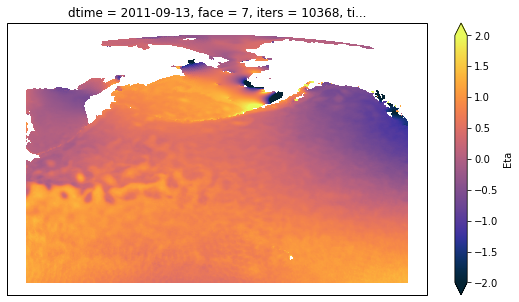

In [19]:
# plot one figure to check lon/lat treatment
dv = ds[v].isel(time=0).sel(face=faces[0])
# for faces that cross the date longitude
dv = dv.assign_coords(XC=((dv.XC+180.)% 360))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cmap = cm.thermal
#cmap = cm.balance
#cmap = plt.get_cmap('RdGy_r')
dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
        cmap=cmap)
ax.grid()
#ax.grid()
#dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=3., vmax=30., cmap=cmap)
#dv.plot(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), cmap=cmap)

---

# make movie

In [9]:

# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def genfig(ds, v, i, pretty=True, overwrite=True):
        
    # !! passing the variable does not work
    dv = ds[v]

    #time = pd.to_datetime(str(eta['time'].values))
    #time = dv['time'].values/86400.
    time = pd.to_datetime(dv['dtime'].values)
    #figname = figdir+'%s_f%d_t%05d' %(v, face, i)+'.png'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        if pretty:
            hdl = plot_pretty(dv, vmin=vmin, vmax=vmax, region=params,
                                  colorbar=True, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=True, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


Process all times: does not work

Useful to see a couple of figures

In [10]:
#I = range(len(ds['time'])) # does not work
I = range(10)
values = [delayed(genfig)(ds.isel(time=i), v, i) for i in I]

In [11]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 2.05 s, sys: 176 ms, total: 2.23 s
Wall time: 21.3 s


Process a selection of times

In [15]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6750,8000)
#II = np.array_split(rg,len(rg)/20) # 4 maybe will work
II = np.array_split(rg,len(rg)/12/20) # 12*20 corresponds to the number of workers
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    #lds = ds.isel(time=slice(I[0],I[-1]+1))
    #values = [delayed(genfig)(lds.isel(time=i), v, I[i]) for i in range(len(I))]
    values = [delayed(genfig)(ds.isel(time=i), v, i, overwrite=False) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

5 loops to be done
6750 - 6999
CPU times: user 16 s, sys: 1.05 s, total: 17.1 s
Wall time: 34.1 s
7000 - 7249
CPU times: user 29.8 s, sys: 1.98 s, total: 31.7 s
Wall time: 1min 26s
7250 - 7499
CPU times: user 30.3 s, sys: 2.25 s, total: 32.6 s
Wall time: 1min 28s
7500 - 7749
CPU times: user 31.5 s, sys: 2.22 s, total: 33.7 s
Wall time: 1min 27s
7750 - 7999
CPU times: user 30.2 s, sys: 2.16 s, total: 32.4 s
Wall time: 1min 23s


In [ ]:
cluster.close()

---

### another strategy: load data in each loop

In [24]:
# could delete all figures beforehand
figdir = scratch+'figs/'
print('Figures directory: '+figdir)

def load_and_genfig(v, i, pretty=True, overwrite=True):
    
    region = 'south-atlantic'
    figname = figdir+'%s_%s_t%05d' %(v, region, i)+'.png'

    if not os.path.isfile(figname) or overwrite:

        grd = load_grd()
        if v in ['Eta','SST','SSS']:
            ds = load_data(v).isel(time=i)
        elif v in ['SSU','SSV','SSU_geo','SSV_geo']:
            dsu = load_data('SSU').rename({'i_g':'i'}).isel(time=i)
            dsv = load_data('SSV').rename({'j_g':'j'}).isel(time=i)
            ds = xr.merge([dsu, dsv])      
        ds = (ds.assign_coords(XC=grd.XC, YC=grd.YC)
               .drop(['Depth','rA', 'hFacC']))

        # rotate if necessary
        if v in ['SSU','SSV','SSU_geo','SSV_geo']:
            ds['SSU_geo'], ds['SSV_geo'] = rotate(ds.SSU, ds.SSV, ds)
            ds = ds.drop(['SSU','SSV'])
            if v is 'SSU': v = 'SSU_geo' 
            if v is 'SSV': v = 'SSV_geo'

        dv = ds[v]
        time = pd.to_datetime(dv['dtime'].values)
        #title = 'eta %.2f' %time
        title = '%s %s' %(v, time.strftime('%Y/%m/%d %Hh'))
        
        if pretty:
            hdl = plot_pretty(dv, vmin=vmin, vmax=vmax, region=params,
                                  colorbar=False, title=title, savefig=figname,
                                  offline=True)
        else:
            figs, ax = plot_scalar(dv, vmin=vmin, vmax=vmax, 
                                   colorbar=False, title=title, savefig=figname,
                                   offline=True, coast_resolution=None, figsize=(15,10))
        #
        #m = float(dv.mean().values)
        m = 1.
    else:
        m = -1.
    return m

Figures directory: /home/mp/pontea/scratch/figs/


In [ ]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
I = II[0]
print('%d - %d'%(I[0],I[-1]))
values = [delayed(load_and_genfig)(v, i) for i in I]    
futures = client.compute(values)
%time results = client.gather(futures)

In [11]:
#II = np.array_split(np.arange(len(ds['time'])),len(ds['time'])/20) # 4 maybe will work
rg = range(6000,8000)
II = np.array_split(rg,len(rg)/20) # 4 maybe will work
print('%d loops to be done'%len(II))
for I in II:
    print('%d - %d'%(I[0],I[-1]))
    values = [delayed(load_and_genfig)(v, i) for i in I]    
    futures = client.compute(values)
    %time results = client.gather(futures)

100 loops to be done
6000 - 6019
CPU times: user 1min 15s, sys: 4.26 s, total: 1min 20s
Wall time: 2min 45s
6020 - 6039
CPU times: user 1min 9s, sys: 3.75 s, total: 1min 13s
Wall time: 2min 37s
6040 - 6059
CPU times: user 1min 10s, sys: 4.17 s, total: 1min 14s
Wall time: 2min 44s
6060 - 6079
CPU times: user 1min 11s, sys: 4.32 s, total: 1min 16s
Wall time: 2min 44s
6080 - 6099
CPU times: user 1min 11s, sys: 4.25 s, total: 1min 15s
Wall time: 2min 38s
6100 - 6119
CPU times: user 1min 11s, sys: 4.26 s, total: 1min 15s
Wall time: 2min 43s
6120 - 6139
CPU times: user 1min 8s, sys: 4.12 s, total: 1min 12s
Wall time: 2min 40s
6140 - 6159
CPU times: user 1min 12s, sys: 4.45 s, total: 1min 16s
Wall time: 2min 47s
6160 - 6179
CPU times: user 1min 16s, sys: 4.78 s, total: 1min 21s
Wall time: 2min 49s
6180 - 6199
CPU times: user 1min 12s, sys: 4.35 s, total: 1min 17s
Wall time: 2min 47s
6200 - 6219
CPU times: user 1min 10s, sys: 4.04 s, total: 1min 14s
Wall time: 2min 40s
6220 - 6239
CPU times: u

CPU times: user 1min 13s, sys: 4.25 s, total: 1min 17s
Wall time: 2min 46s
7920 - 7939
CPU times: user 1min 14s, sys: 4.4 s, total: 1min 19s
Wall time: 2min 54s
7940 - 7959
CPU times: user 1min 14s, sys: 4.43 s, total: 1min 19s
Wall time: 2min 55s
7960 - 7979
CPU times: user 1min 13s, sys: 4.4 s, total: 1min 17s
Wall time: 2min 45s
7980 - 7999
CPU times: user 1min 11s, sys: 4.19 s, total: 1min 15s
Wall time: 2min 40s


In [12]:
cluster.close()

```
ffmpeg -f image2 -r 20 -pattern_type glob -i "./figs/*_t00*.png" -q:v 1 ./out.mp4
```

---

# individual figures

(for colormaps ...)

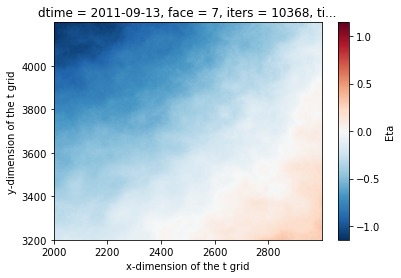

In [27]:
ds[v].isel(time=0).plot(x=ds.)

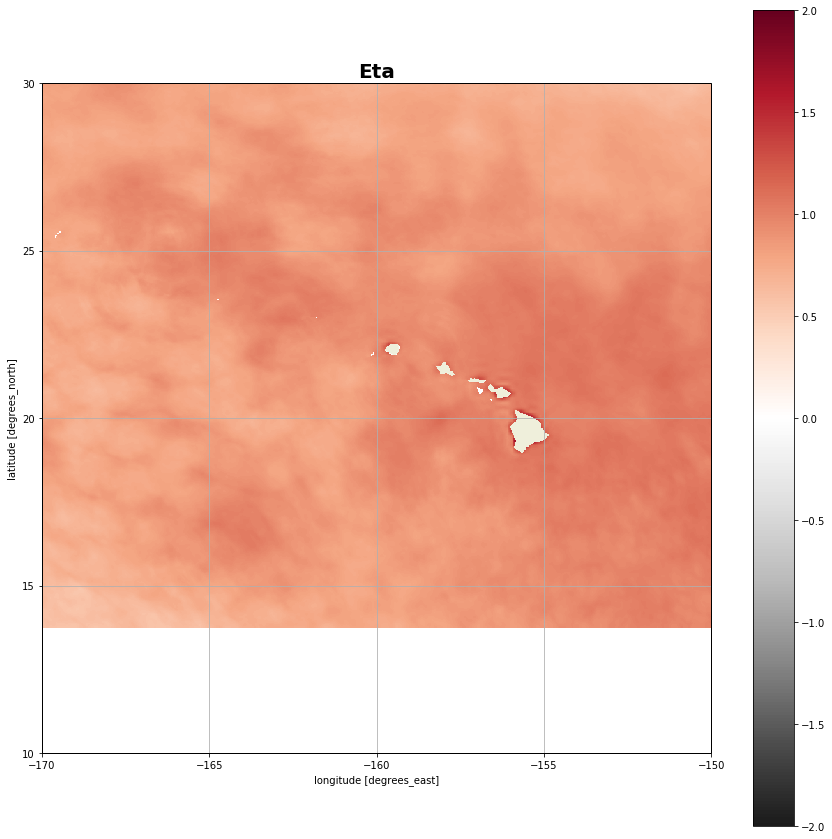

In [42]:
hdl = plot_pretty(ds[v].isel(time=0), vmin=vmin, vmax=vmax, region=params,
                      title=v, colorbar=True)

---

# info, shutdown

In [ ]:
cluster.close()

In [ ]:
client.restart()